In [2]:
import matplotlib.pyplot as plt
import torch
import libs.angular_spectrum as AS
import libs.forward_model as fm
import numpy as np


### Verification

In [19]:
# Parameter Definition
NA = .8
Rindex= 1
lambda_= 532.0/ 1000 #um
dx,dy, dz= 1/3,1/3, 1. #um
ep_dx, ep_dy = 2,2  #um
Nx,Ny,Nz = 41,41,41


fm.init_parameters(NA_ = NA, Rindex_= Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD(ep_dx_=ep_dx, ep_dy_=ep_dy)
aNs = AS.d2nnASwWindow_layer(Nx, Ny, dx, dy, dz, lambda_,window_size=8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Sucessfully Initialized Point Spread Function...!!!


In [20]:
# Field Via Debye Theory

ht_3D = torch.zeros(1, Nz, Nx, Ny).float().to(device)
ht_3D[:, Nz // 2] = fm.ht_2D
debye_result = fm.conv_3D(fm.exPSF_3D, ht_3D).sum(dim=0).to('cpu')

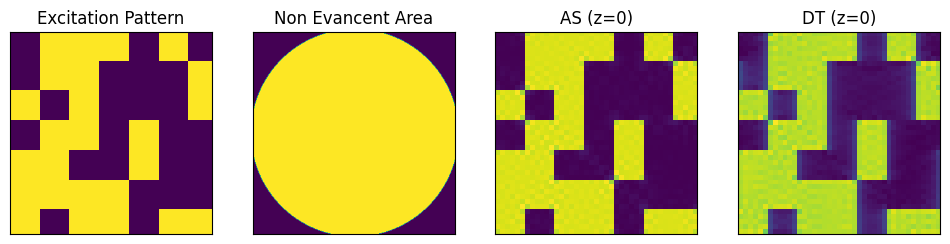

In [21]:
# Field Via Angular Spectrum Method
as_result = torch.zeros(Nz, Nx,Ny, dtype=torch.complex64)
mask_factor = 1/1.5

for i in range(-Nz//2, Nz//2+1):
    aNs.find_transfer_function(dz*i,mask_factor_=mask_factor)
    output_field = aNs.forward(fm.ht_2D.unsqueeze(0))
    field = (output_field.abs()).detach()
    as_result[i+Nz//2] = output_field

    if (i==0):

        fig, axes = plt.subplots(1,4, figsize=(12, 3))
        axes[0].imshow(fm.ht_2D), axes[0].set_title("Excitation Pattern")
        axes[1].imshow(AS.non_evancent_area), axes[1].set_title("Non Evancent Area")
        axes[2].imshow(field[0]), axes[2].set_title(f"AS (z={i})")
        axes[3].imshow(debye_result[Nz//2].abs()), axes[3].set_title(f"DT (z={i})")
        plt.setp(axes, xticks=[], yticks=[])
        plt.show()

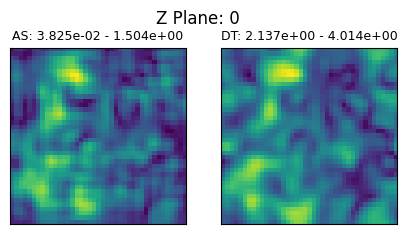

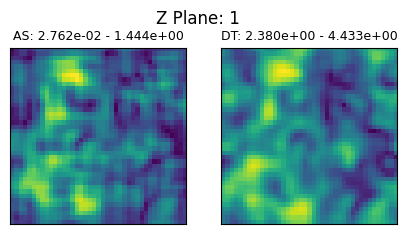

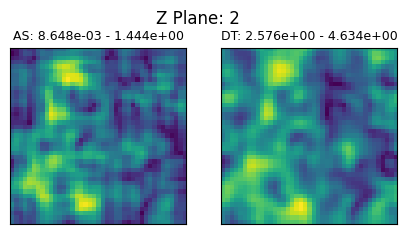

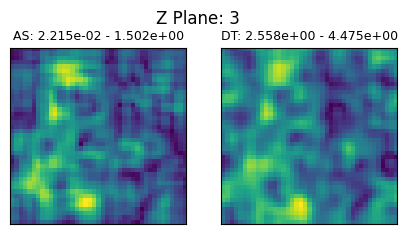

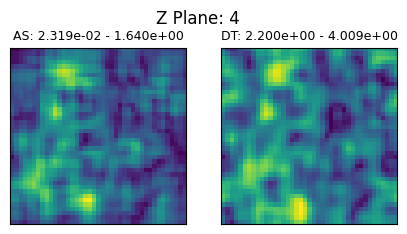

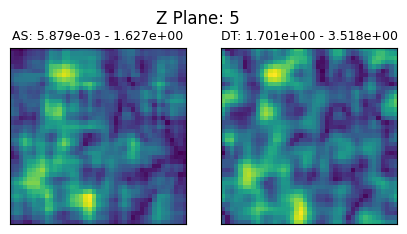

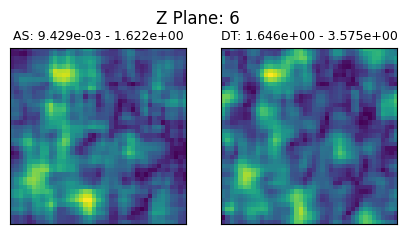

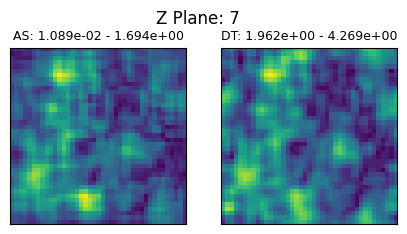

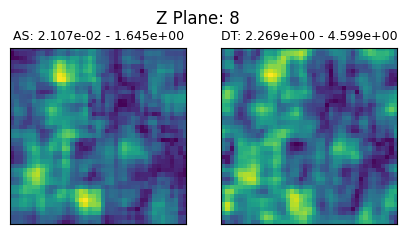

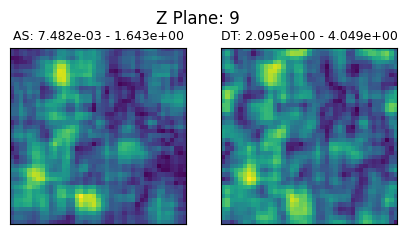

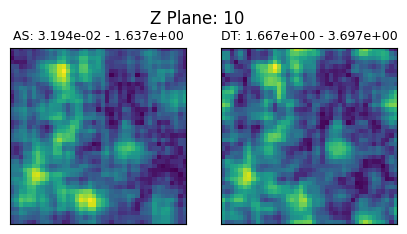

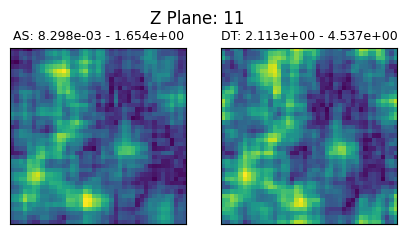

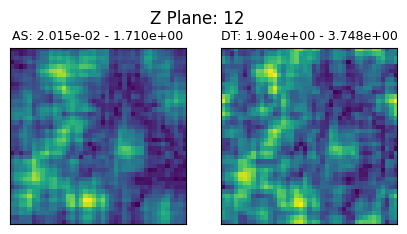

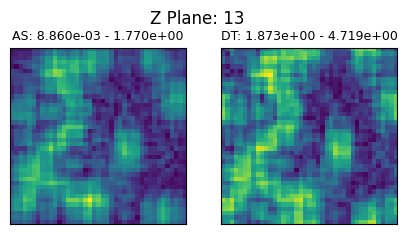

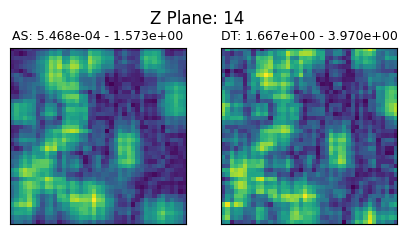

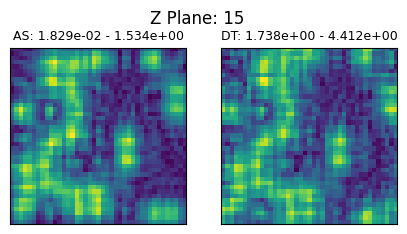

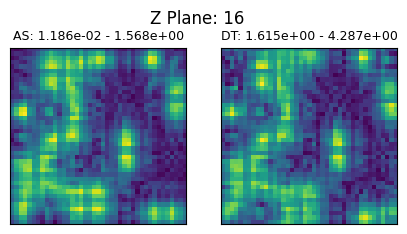

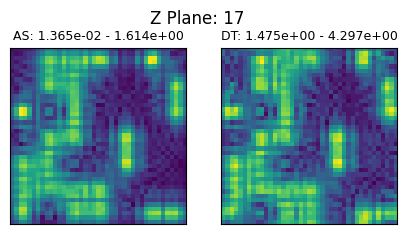

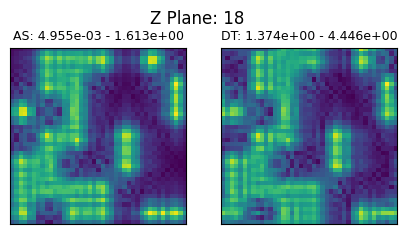

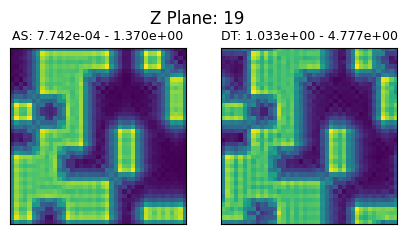

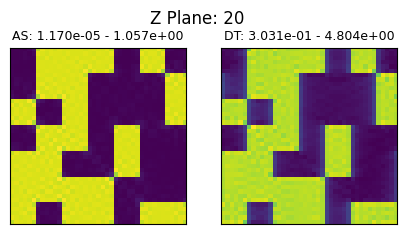

In [22]:
# Field Comparision
# as_result = (as_result.abs() - as_result.abs().min())/(as_result.abs().max()-as_result.abs().min())
# debye_result = (debye_result.abs() - debye_result.abs().min())/(debye_result.abs().max()-debye_result.abs().min())
for i in range( Nz//2+1):
    fig, axes = plt.subplots(1,2, figsize=(5, 2.6))
    fig.suptitle(f"Z Plane: {i}")
    axes[0].imshow(as_result[i].abs().detach())
    axes[0].set_title("AS: "+"{:.3e}".format(as_result[i].abs().min())+" - "+"{:.3e}".format(as_result[i].abs().max()),fontsize=9)
    axes[1].imshow(debye_result[i].abs())
    axes[1].set_title("DT: "+"{:.3e}".format(torch.quantile(debye_result[i].abs(),.25))+" - "+"{:.3e}".format(torch.quantile(debye_result[i].abs(),.75)),fontsize=9)
    plt.setp(axes, xticks=[], yticks=[])
    plt.show()